# Tree-based Methods (Métodos Baseados em Árvores)

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo
* Introdução
* Árvore de Decisão
  * Árvore de Regressão (Regression Trees);
  * Poda de Árvore de Regressão (Regression Tree Pruning);
  * Árvore de Classificação (Classification Trees);
  * Poda de Árvore de Classificação (Classification Tree Pruning);
* Conjunto de Árvores (Ensemble of Trees)
  * Bagging (Bootstrap Aggregating);
  * Random Forests;
  * Boosting;
  * Bayesian Additive Regression Trees (BART);
* Aplicações em Python
* Considerações Finais


### Referências

* [An Introduction to Statistical Learning](https://www.statlearning.com/) (ISL) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani
  * Capítulo 8
* [The Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) (ESL) by Trevor Hastie, Robert Tibshirani and Jerome Friedman
  * Capítulos 15, 16


***Disclaimer:*** *O material apresentado aqui é uma adaptação do material de aula do Prof. Daniel de Abreu Pereira Uhr, e não deve ser utilizado para fins comerciais. O material é disponibilizado para fins educacionais e de pesquisa, e não deve ser reproduzido sem a devida autorização do autor. Este material pode conter erros e imprecisões. O autor não se responsabiliza por quaisquer danos ou prejuízos decorrentes do uso deste material. O uso deste material é de responsabilidade exclusiva do usuário. Caso você encontre erros ou imprecisões neste material, por favor, entre em contato com o autor para que possam ser corrigidos. O autor agradece qualquer feedback ou sugestão de melhoria.*

In [4]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

# Import matplotlib for graphs
import matplotlib.pyplot as plt
# Set global parameters
plt.style.use('seaborn-v0_8-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,7)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

### 1. Introdução

Nesta aula, estudaremos os métodos baseados em árvores para modelagem eeconométrica e aprendizado de máquina (Machine Learning), com foco tanto nos aspectos conceituais quanto em aplicações práticas.

Ao final da aula, espera-se que o aluno seja capaz de:

* Compreender o funcionamento de uma árvore de decisão;
* Distinguir entre Árvores de Regressão e Árvores de Classificação;
* Compreender o conceito de *Bagging* e como ele contribui para o desempenho dos modelos;
* Entender o funcionamento das *Random Forests* e suas vantagens em relação às árvores individuais;
* Compreender o conceito de *Boosting* e sua contribuição para a performance preditiva;
* Explorar o modelo *Bayesian Additive Regression Trees* (BART) e suas principais características;
* Aplicar os conceitos aprendidos em exemplos práticos utilizando a linguagem Python.

### 2. Decision Tree (Árvore de Decisão)

As árvores de decisão envolvem a estratificação ou segmentação do espaço dos preditores em regiões simples e distintas. Para realizar uma previsão para uma nova observação, normalmente utilizamos a média (em problemas de regressão) ou a moda (em problemas de classificação) das observações de treinamento que pertencem à mesma região.

Como o conjunto de regras de divisão pode ser representado graficamente por uma estrutura hierárquica em forma de árvore, esses métodos são conhecidos como métodos baseados em árvores de decisão.


### 2.1. Árvore de Regressão

Vamos introduzir o conceito de árvore de decisão a partir do caso de regressão, onde o objetivo é prever uma variável contínua. As árvores de regressão são construídas dividindo o espaço dos preditores em regiões homogêneas, onde cada região é associada a uma previsão específica. Nosso caso específico envolve prever o salário de jogadores de beisebol com base em duas características: `Hits` (número de rebatidas) e `Years` (número de anos jogados) - *Predicting Baseball Players’ Salaries Using Regression Trees*.


<div style="text-align:center;">
    <img src="images\Fig_8_1.png"  alt="Imagem" style="width: 650px;"/>
</div>


Nesta sessão, consideraremos o conjunto de dados `Hitters`. Ele consiste em dados individuais de jogadores de beisebol. Em nossas aplicações, estamos interessados ​​em prever os salários dos jogadores - *Salary*.

In [5]:
# Load the data
hitters = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters.csv').dropna()
hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N
5,-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,...,501,336,194,A,W,282,421,25,750.0,A


5 linhas × 21 colunas

Em particular, estamos interessados ​​em observar como o número de `Hits` e a anos de experiência (`Years`) preveem o `Salary`. vamos criar uma variável com as variáveis explicativas (features, X) e a variável resposta (target, y):

In [6]:
features = ['Years', 'Hits']
X = hitters[features].values
y = np.log(hitters.Salary.values)

Repare que utilizamos o log(salário), pois ele tem uma distribuição mais gaussiana:

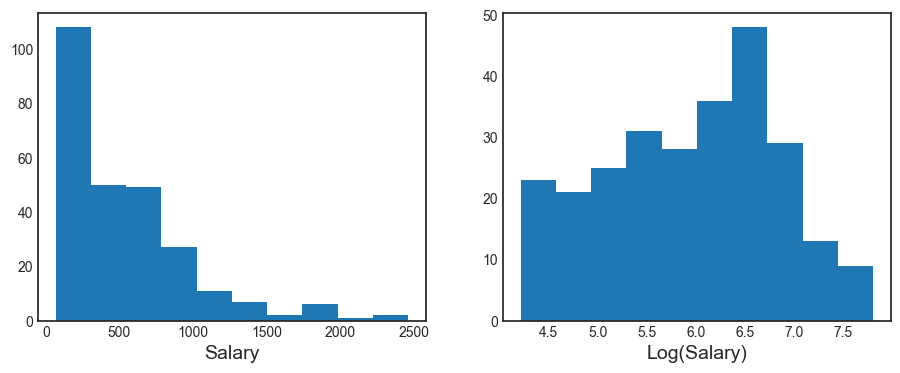

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(11,4))

# Plotando a distribuição de salary
ax1.hist(hitters.Salary.values)
ax1.set_xlabel('Salary')
ax2.hist(y)
ax2.set_xlabel('Log(Salary)');

Para entender o que é uma árvore, vamos primeiro dar uma olhada em uma. 

Vamos ajustar uma regressão com no máximo 3 folhas (3 regiões finais de decisão)

In [8]:
# Ajustando a arvore de decisão com 3 folhas
tree = DecisionTreeRegressor(max_leaf_nodes=3)
# treinando a arvore de decisão
tree.fit(X, y)

DecisionTreeRegressor(max_leaf_nodes=3)

Agora, vamos plotar os resultados visualmente. Repare que a maior vantagem das árvores é a interpretabilidade.

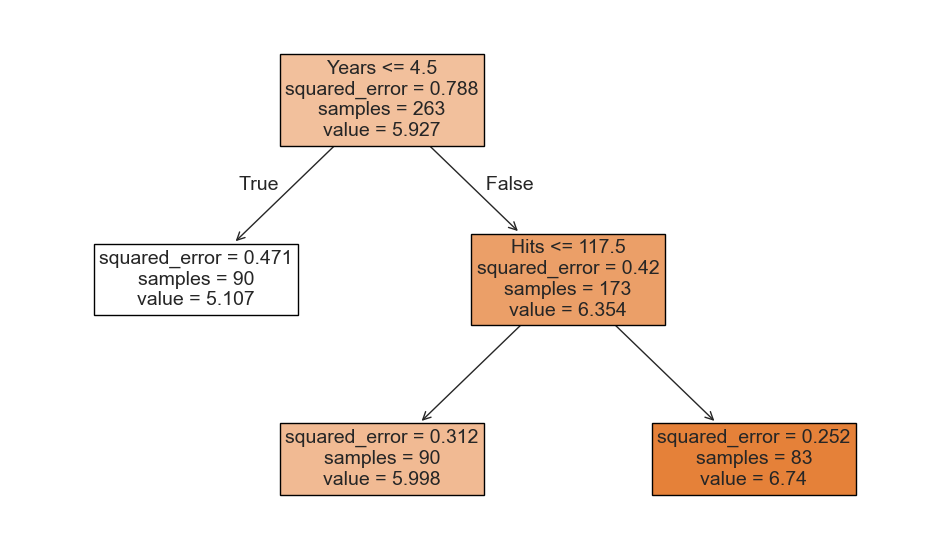

In [9]:
# Figura 8.1
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 8.1');

# Plot tree
plot_tree(tree, filled=True, feature_names=features, fontsize=14, ax=ax);

***Raiz da Árvore***

O primeiro critério de divisão escolhido pelo algoritmo foi a variável Years (anos de experiência).
* A divisão ocorre em dois grupos:
  * Jogadores com Years ≤ 4.5 (ramo esquerdo)
  * Jogadores com Years > 4.5 (ramo direito)
* No nó da raiz, temos:
  * squared_error = 0.788: erro quadrático médio (variância) dos salários dentro do grupo inteiro (antes da divisão).
  * samples = 263: número total de jogadores considerados neste ponto.
  * value = 5.927: média dos salários (em log ou milhares de dólares) de todos os jogadores no conjunto original.

***Ramo Esquerdo (Years ≤ 4.5)***

Como não há divisão adicional, esse nó se torna uma folha.

* Valores:
  * squared_error = 0.471
  * samples = 90
  * value = 5.107: salário médio dos jogadores com até 4,5 anos de experiência.

Isso significa que todas as observações que satisfazem Years ≤ 4.5 caem nessa folha, e recebem a predição de salário igual a 5.107.

***Ramo Direito (Years > 4.5)***

Esse nó passa por uma nova divisão baseada na variável Hits (número de rebatidas):
* Hits ≤ 117.5: ramo esquerdo
* Hits > 117.5: ramo direito
* Valores no nó intermediário:
  * squared_error = 0.42
  * samples = 173
  * value = 6.354: média dos salários entre os jogadores com mais de 4,5 anos de experiência.


***Folha esquerda do nó direito (Hits ≤ 117.5)***

* squared_error = 0.312
* samples = 90
* value = 5.998

Jogadores com mais de 4,5 anos de experiência e menos de 117,5 rebatidas têm salário médio de 5.998.


***Folha direita do nó direito (Hits > 117.5)***

* squared_error = 0.252
* samples = 83
* value = 6.740

Jogadores com mais de 4,5 anos de experiência e mais de 117,5 rebatidas têm salário médio de 6.740.


No geral, ***a árvore estratifica ou segmenta os jogadores*** em três regiões do espaço preditor:

* jogadores que jogaram por quatro anos ou menos
* jogadores que jogaram por cinco ou mais anos e que fizeram menos de 118 rebatidas no ano passado, e
* jogadores que jogaram por cinco anos ou mais e que fizeram pelo menos 118 rebatidas no ano passado.


Essas três regiões podem ser escritas como:

* $R1 = \{X | Years<4,5 \}$
* $R2 = \{X | Years>=4,5, Hits<117,5\}$, e
* $R3 = \{X | Years>=4,5, Hits>=117,5\}$.

Podemos visualizar o espaço e as regiões em um gráfico bidimensional:

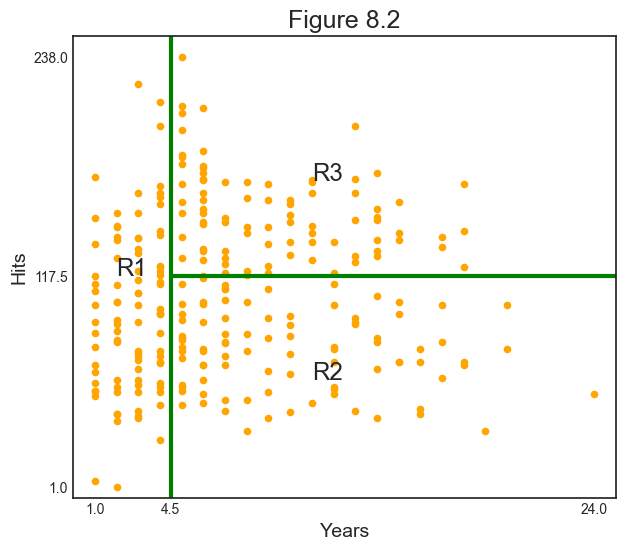

In [10]:
# Figura 8.2
def make_figure_8_2():
    
    # Init
    hitters.plot('Years', 'Hits', kind='scatter', color='orange', figsize=(7,6))
    plt.title('Figure 8.2')
    plt.xlim(0,25); plt.ylim(ymin=-5);
    plt.xticks([1, 4.5, 24]); plt.yticks([1, 117.5, 238]);

    # Split lines
    plt.vlines(4.5, ymin=-5, ymax=250, color='g')
    plt.hlines(117.5, xmin=4.5, xmax=25, color='g')

    # Regions
    plt.annotate('R1', xy=(2,117.5), fontsize='xx-large')
    plt.annotate('R2', xy=(11,60), fontsize='xx-large')
    plt.annotate('R3', xy=(11,170), fontsize='xx-large');

make_figure_8_2()

**Procedimento para construção de uma árvore**

A cada etapa, fazemos:

1. Selecionamos o preditor $X_j$ e o ponto de corte $s$;
2. Dividimos o espaço preditor nas regiões:
   - $R_1(j, s) = \{ X \mid X_j < s \}$
   - $R_2(j, s) = \{ X \mid X_j \geq s \}$

3. Calculamos a **RSS total** após a divisão:

$$
\sum_{i: x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2
$$

4. Repetimos os passos acima para **todos os preditores** e **todos os possíveis valores de corte $s$**, escolhendo aquele que **minimiza a soma total do erro**:

$$
\arg \min_{j, s} \left\{ \sum_{i: x_i \in R_1(j, s)} (y_i - \hat{y}_{R_1})^2 + \sum_{i: x_i \in R_2(j, s)} (y_i - \hat{y}_{R_2})^2 \right\}
$$

5. Repetimos esse processo recursivamente, dividindo as regiões formadas, até que alguma **condição de parada** seja atingida (como número mínimo de observações por folha ou profundidade máxima da árvore).


### 2.2. Poda da Árvore de Regressão (*Regression Tree Pruning*)

O processo de construção de uma árvore de regressão, como vimos anteriormente, pode resultar em uma árvore muito complexa, com várias divisões. Embora essa complexidade permita que o modelo se ajuste muito bem aos dados de treinamento, ela frequentemente leva ao problema conhecido como **overfitting** (ou sobreajuste). Nesse caso, a árvore "aprende" os ruídos e variações específicas do conjunto de treinamento, perdendo capacidade de generalização.

Em termos estatísticos, uma árvore muito complexa tende a apresentar ***baixa variância in-sample*** (no conjunto de treino), mas ***alta variância out-of-sample*** (no conjunto de teste), resultando em desempenho preditivo inferior.

Uma estratégia para mitigar esse problema é a ***poda da árvore (*pruning*)***, que consiste em reduzir o número de divisões (ou folhas) da árvore com o ***objetivo de diminuir a variância e aumentar a capacidade de generalização*** (análogo ao conceito de ***regularização*** em modelos lineares).

Podemos ver isso acontecendo se construirmos a mesma árvore acima, mas com 5 folhas.

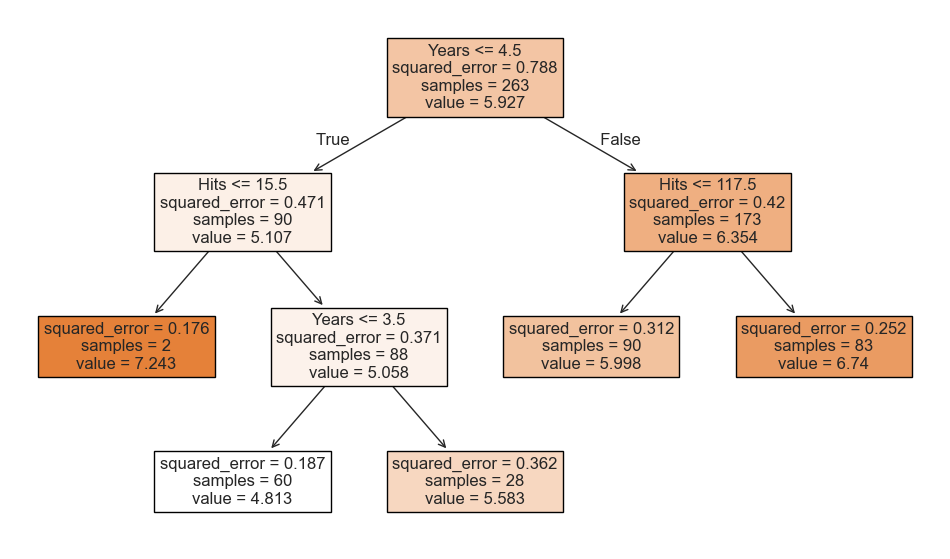

In [11]:
# Compute tree
overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5).fit(X, y)
# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(overfit_tree, filled=True, feature_names=features, fontsize=12, ax=ax);

Na nova árvore, observamos que a divisão mais à esquerda produz uma previsão de $Salary = 7.243$ para jogadores com pouca experiência (*Years*) e poucos *Hits*. No entanto, essa predição é baseada em apenas 2 observações, o que sugere que provavelmente são outliers. Isso é um claro indício de que a árvore está superajustada ao conjunto de treinamento.

***Restringindo o número mínimo de observações por folha***

Uma maneira de evitar esse tipo de superajuste é ***exigir que cada folha tenha um número mínimo de observações***. Por exemplo, vamos ajustar uma árvore com no máximo 5 folhas, mas exigindo pelo menos 10 observações por folha:

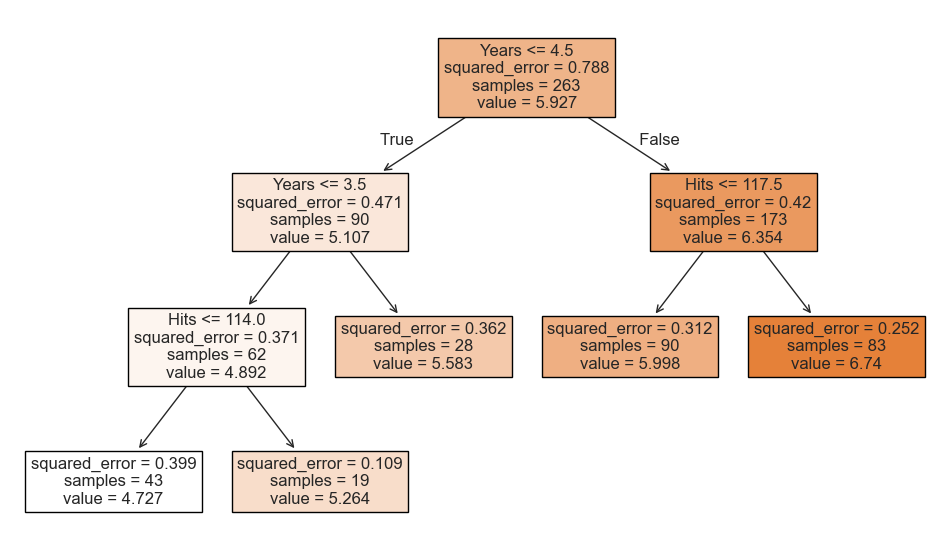

In [12]:
# Compute tree
no_overfit_tree = DecisionTreeRegressor(max_leaf_nodes=5, min_samples_leaf=10).fit(X, y)

# Plot tree
fig, ax = plt.subplots(1,1)
plot_tree(no_overfit_tree, filled=True, feature_names=features, fontsize=12, ax=ax);

Agora, a árvore resultante é mais estável e interpretável:

* Jogadores com menos experiência (*Years*) e menos rebatidas (*Hits*) tendem a ter salários mais baixos.
* Essa relação é evidenciada visualmente pelos tons de cor se tornando mais escuros à medida que nos movemos da esquerda (menores salários) para a direita (salários mais altos).

***Outras abordagens para controle da complexidade***

Uma alternativa à imposição de um número mínimo de observações por folha é ***permitir que a árvore cresça apenas enquanto a redução no RSS*** (*residual sum of squares*) proporcionada por uma divisão for ***superior a um determinado limiar***. Essa estratégia tende a produzir árvores menores, mas pode ser míope, pois uma divisão pouco informativa no início pode dar origem a subdivisões boas posteriormente.


***Escolhendo o tamanho ótimo da árvore: Validação cruzada***

Uma ***abordagem mais robusta*** para definir o tamanho ideal da árvore é utilizar **validação cruzada**, comparando o desempenho preditivo de árvores com diferentes profundidades ou números de folhas. Nas próximas etapas, vamos explorar esse caminho, utilizando dados de treinamento e teste, além de incluir novas variáveis explicativas.

In [13]:
# Import original split
features = ['Years', 'Hits', 'RBI', 'PutOuts', 'Walks', 'Runs', 'AtBat', 'HmRun']

In [17]:
X_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_train.csv').dropna()[features]

In [19]:
X_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_X_test.csv').dropna()[features]

In [21]:
y_train = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_train.csv').dropna()

In [26]:
y_test = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Hitters_y_test.csv').dropna()

***OBS: Se der erro ao carregar o dataset, execute o comando mais vezes até que ele carregue corretamente.***

Esse código Python abaixo faz uma busca pelo número ideal de folhas (`max_leaf_nodes`) para uma árvore de regressão, utilizando validação cruzada com o objetivo de minimizar o erro de previsão. 

Ou seja:

* Avaliar o desempenho do modelo `DecisionTreeRegressor` para diferentes tamanhos de árvore (número de folhas de 2 a 10), comparando o erro de:
  * Treinamento
  * Teste
  * Validação cruzada (com 6 folds)
  
Por fim, ele identifica o melhor número de folhas com base no menor erro de validação cruzada.

In [27]:
# Init
params = range(2,11)
reg_scores = np.zeros((len(params),3))
best_score = 10**6

# Loop over all parameters
for i,k in enumerate(params):
    
    # Model
    tree = DecisionTreeRegressor(max_leaf_nodes=k)

    # Loop over splits
    tree.fit(X_train, y_train)
    reg_scores[i,0] = mean_squared_error(tree.predict(X_train), y_train)
    reg_scores[i,1] = mean_squared_error(tree.predict(X_test), y_test)

    # Get CV score
    kf6 = KFold(n_splits=6)
    reg_scores[i,2] = -cross_val_score(tree, X_train, y_train, cv=kf6, scoring='neg_mean_squared_error').mean()
    
    # Save best model
    if reg_scores[i,2]<best_score:
        best_model = tree
        best_score = reg_scores[i,2]

Agora, vamos gerar uma figura com dois gráficos lado a lado para ilustrar visualmente:
* O desempenho dos modelos com diferentes números de folhas (gráfico à esquerda);
* A árvore de decisão que obteve o melhor resultado de validação cruzada (gráfico à direita).

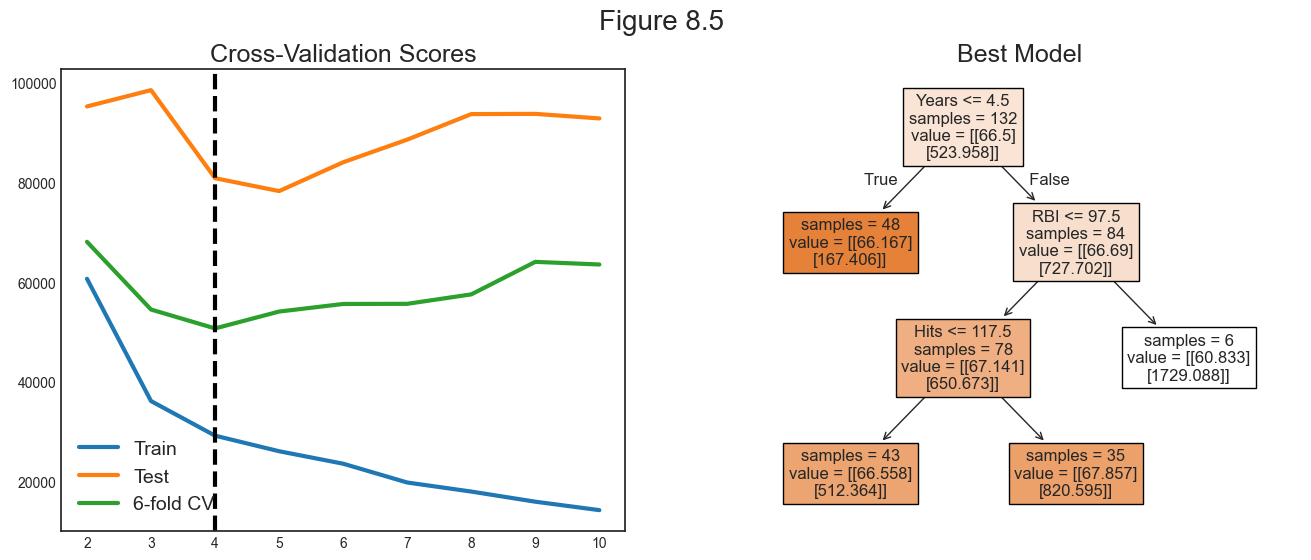

In [28]:
# Figure 8.5
def make_figure_8_5():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    fig.suptitle('Figure 8.5')

    # Plot scores
    ax1.plot(params, reg_scores);
    ax1.axvline(params[np.argmin(reg_scores[:,2])], c='k', ls='--')
    ax1.legend(['Train','Test','6-fold CV']);
    ax1.set_title('Cross-Validation Scores');

    # Plot best tree
    plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);
    ax2.set_title('Best Model');

make_figure_8_5()

O termo *Cross-Validation Scores* se refere às métricas de erro obtidas durante a validação cruzada de diferentes versões do modelo de árvore de decisão. 

Descrição do gráfico:
* Eixo X → Número de folhas da árvore (`max_leaf_nodes`) variando de 2 a 10.
* Eixo Y → Erro quadrático médio (quanto menor, melhor).

Interpretação do gráfico:
* O erro de treino (linha azul) diminui continuamente conforme o número de folhas aumenta. Isso é esperado: quanto mais complexa a árvore, melhor ela "memoriza" o conjunto de treinamento.
* O erro de teste (laranja) e o erro de validação cruzada (verde) atingem um mínimo próximo de 4 folhas. Depois disso, começam a subir — sinal de *overfitting*.
* A linha vertical tracejada preta marca o ponto ótimo escolhido pela validação cruzada (número de folhas que minimiza o erro médio em CV, aqui: 4 folhas).

A árvore à direita representa o modelo vencedor (com 4 folhas), e pode ser usada como preditor final. 

### 2.3. Árvore de Classificação

Uma árvore de classificação é conceitualmente semelhante a uma árvore de regressão, mas é utilizada quando a variável resposta é qualitativa (ou categórica), em vez de quantitativa. A ideia central é a mesma: segmentar o espaço dos preditores em regiões, mas agora o modelo prevê que cada observação pertença à classe mais comum entre as observações de treinamento dentro da mesma região terminal (folha).

O processo de construção de uma árvore de classificação é análogo ao da regressão, porém com uma diferença crucial:

>
>Como o objetivo é prever categorias, e não valores contínuos, não podemos utilizar a Soma dos Quadrados dos Resíduos (RSS) como critério de divisão.
>

Em seu lugar, utilizamos ***medidas de impureza***, que indicam o grau de heterogeneidade de um nó. Quanto mais "puro" for o nó (isto é, quanto mais ele concentrar observações de uma única classe), melhor é a divisão.

Seja $\hat{p}_{mk}$ a proporção de observações de treinamento no nó $m$ que pertencem à classe $k$.

**Métricas de Impureza**

Três métricas comuns para avaliar a qualidade das divisões são:

***Taxa de Erro de Classificação***

Mede a proporção de observações que não pertencem à classe majoritária dentro do nó:

$$
\text{Taxa de Erro} = 1 - \max_k \hat{p}_{mk}
$$

* ***Quanto menor a taxa de erro, mais puro é o nó***.

***Índice de Gini***
O índice de Gini mede a probabilidade de que duas observações escolhidas aleatoriamente pertençam a classes diferentes:
$$
\text{Índice de Gini} = 1 - \sum_k \hat{p}_{mk}^2
$$

* ***Quanto menor o índice de Gini, mais puro é o nó***.

***Entropia (ou Impureza de Shannon)***

A entropia mede a incerteza ou aleatoriedade das classes dentro do nó:
$$
\text{Entropia} = -\sum_k \hat{p}_{mk} \log(\hat{p}_{mk})
$$
* ***Quanto menor a entropia, mais puro é o nó***.

***Qual medida usar na prática?***

Ao construir uma árvore de classificação, **o índice de Gini** e a **entropia** são mais utilizados para avaliar a qualidade das divisões, pois são mais sensíveis à pureza dos nós do que a taxa de erro de classificação. A taxa de erro costuma ser usada apenas na etapa final, para avaliação do desempenho do classificador.


***Exemplo Prático: Dados de Insuficiência Cardíaca***

Vamos trabalhar com o conjunto de dados **Heart**, que contém informações clínicas de pacientes. O objetivo é prever a ocorrência de **doença cardíaca** (variável **ADH**), que é **binária**: *Sim* ou *Não*, a partir do conjunto de características observáveis/preditores/features: utilizaremos variáveis como idade, pressão arterial, nível de colesterol, entre outras.

Nosso objetivo é construir uma árvore de classificação capaz de prever corretamente se um paciente possui ou não histórico de doença cardíaca.

In [29]:
# Load heart dataset
heart = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Heart.csv').drop('Unnamed: 0', axis=1).dropna()
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


OBS: Novamente, caso não carregue, execute o comando mais vezes até que ele carregue corretamente.

Repare que a coluna `heart['ChestPain']` e `heart['Thal']` contém valores categóricos não numéricos. Para utilizar esses dados em uma árvore de decisão, precisamos convertê-los em variáveis numéricas. Vamos fazer isso utilizando o método `factorize()` do Pandas, que converte categorias em números inteiros.
* `pd.factorize()` atribui números em ordem de aparição, sem considerar qualquer ordem inerente nas categorias (ex.: "baixo", "médio", "alto"). Se a ordem importa, considere outras técnicas, como OrdinalEncoder ou mapeamento manual.

In [30]:
# Fastorize variables
heart.ChestPain = pd.factorize(heart.ChestPain)[0]
heart.Thal = pd.factorize(heart.Thal)[0]

o `pd.factorize()` com `[0]` retorna os códigos numéricos das categorias, enquanto [1] retorna os rótulos originais. Aqui, estamos interessados apenas nos códigos numéricos.

In [31]:
# criar uma lista com os nomes das variáveis explicativas (features)
features = [col for col in heart.columns if col!='AHD']

In [32]:
features

['Age',
 'Sex',
 'ChestPain',
 'RestBP',
 'Chol',
 'Fbs',
 'RestECG',
 'MaxHR',
 'ExAng',
 'Oldpeak',
 'Slope',
 'Ca',
 'Thal']

In [33]:
# Definir X e y
X2 = heart[features]
y2 = pd.factorize(heart.AHD)[0]

Agora ajustamos nosso classificador. Sem profundidade máxima (`max_depth=None`), ***a árvore pode crescer e se ajustar aos dados de treinamento***. Vamos apenas limitar em um numero máximo de 11 folhas.

In [34]:
# Fit classification tree
clf = DecisionTreeClassifier(max_depth=None, max_leaf_nodes=11)
clf.fit(X2,y2)

DecisionTreeClassifier(max_leaf_nodes=11)

Qual é a pontuação da acurácia da árvore?

In [35]:
# Final score
clf.score(X2,y2)

0.8686868686868687

O resultado mostra que a árvore de decisão alcançou uma acurácia de 0.8686..., indicando que 86,87% das previsões feitas pelo modelo estão corretas.

Vamos dar uma olhada na árvore inteira.

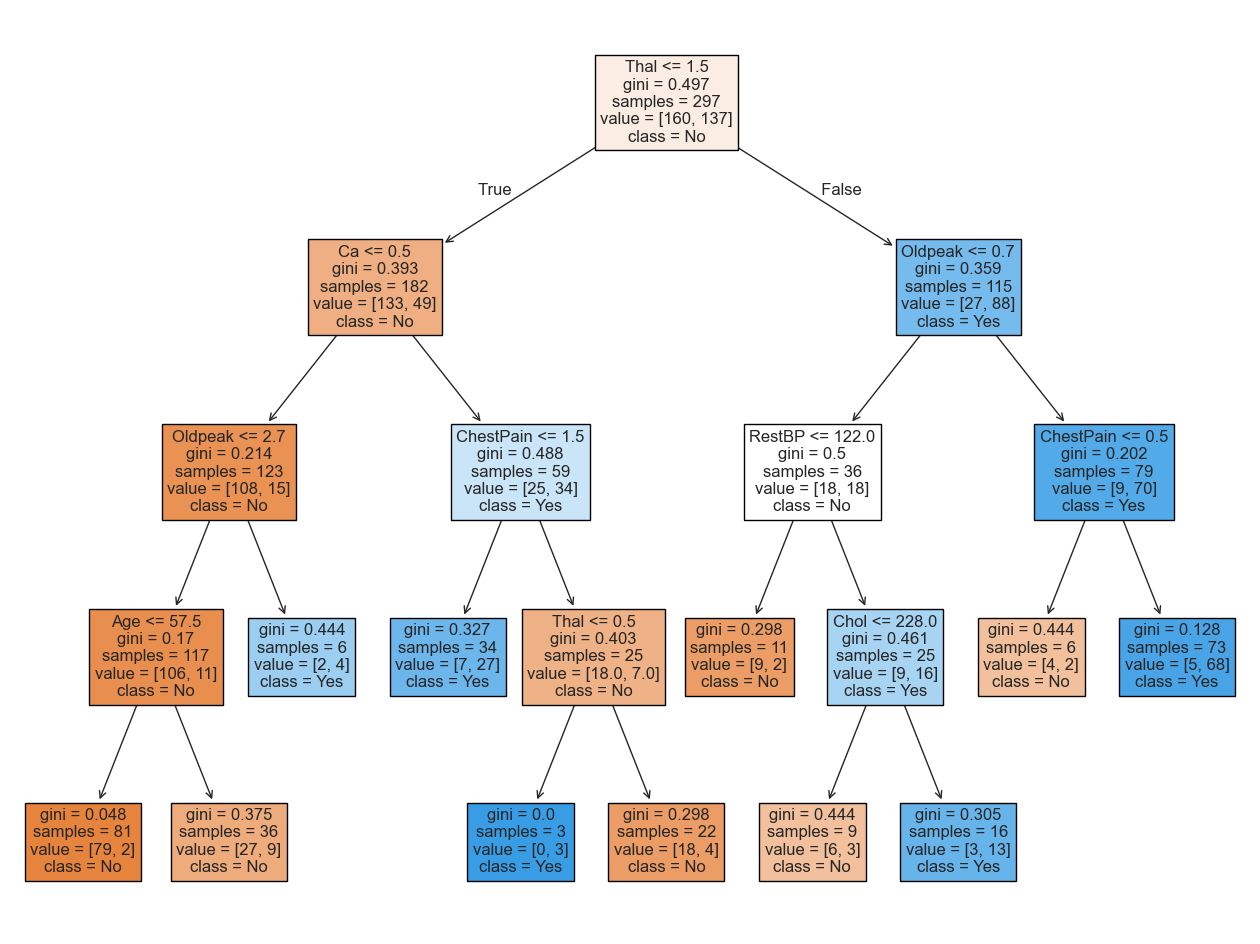

In [36]:
# Figure 8.6 a
def make_fig_8_6a():
    
    # Init
    fig, ax = plt.subplots(1,1, figsize=(16,12))
    ax.set_title('Figure 8.6');

    # Plot tree
    plot_tree(clf, filled=True, feature_names=features, class_names=['No','Yes'], fontsize=12, ax=ax);

make_fig_8_6a()    

**Avaliando a Árvore de Decisão**

Observe o nó de decisão $Age <= 57.5$, ***localizado na parte inferior esquerda***. Ele divide o grupo de 117 amostras em dois novos nós-folha. Repare que ambos os nós-folha têm a mesma previsão final: `class = No`.

***A pergunta natural que surge é:*** Se ambos os caminhos levam à mesma classificação, por que o algoritmo se deu ao trabalho de fazer essa divisão?

A resposta está em um conceito fundamental que vai além da simples classificação: a pureza dos nós.

Vamos olhar os dados com atenção:
* Folha da Esquerda ($Age <= 57.5$ é Verdadeiro):
  * Temos 81 amostras, das quais 79 são "Não" e apenas 2 são "Sim".
  * A probabilidade de uma amostra aqui ser "Sim" é de apenas 2/81, ou $~2.5\% $.
  * A previsão "Não" aqui é feita com altíssima confiança.
* Folha da Direita ($Age <= 57.5$ é Falso):
  * Temos 36 amostras, das quais 27 são "Não" e 9 são "Sim".
  * A probabilidade de uma amostra aqui ser "Sim" é de 9/36, ou $25\% $.
  * A previsão continua sendo "Não" (pois $27 > 9$), mas nossa certeza é bem menor.
* Conclusão: O Algoritmo Prefere a Certeza ao Erro Mínimo (Imediato)

Fica claro que a divisão $Age <= 57.5$ é útil. Ela conseguiu isolar um grupo de 81 pacientes sobre os quais podemos afirmar com muita certeza que o resultado é "Não", separando-os de um grupo menor e mais incerto.

É aqui que entram as ***métricas de construção da árvore, como o Índice Gini*** (mostrado na imagem) e a ***Entropia***. O algoritmo não está apenas tentando minimizar o número de classificações erradas no conjunto de treino; ele está ***tentando criar os grupos mais homogêneos (ou "puros") possíveis a cada passo***.

Uma divisão que aumenta a pureza, como esta, é considerada vantajosa e será realizada, pois:
* Reduz o Índice Gini geral.
* Aumenta o poder preditivo do modelo para novos dados, pois nos dá uma estimativa de probabilidade, e não apenas uma classificação "seca".

Em resumo: A árvore não busca apenas o quê prever, mas também quão confiante ela está nessa previsão. Essa divisão, embora não altere a classe prevista, aprimora a confiança do modelo em suas próprias previsões.

### 2.4. Poda da Árvore de Classificação (*Classification Tree Pruning*)

Podemos repetir o exercício de poda também para a àrvore de classificação.

In [37]:
# Figure 8.6 b
def make_figure_8_6b():
    
    # Init
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle('Figure 8.6')

    # Plot scores
    ax1.plot(params, clf_scores);
    ax1.legend(['Train','Test','6-fold CV']);

    # Plot best tree
    plot_tree(best_model, filled=True, impurity=False, feature_names=features, fontsize=12, ax=ax2);

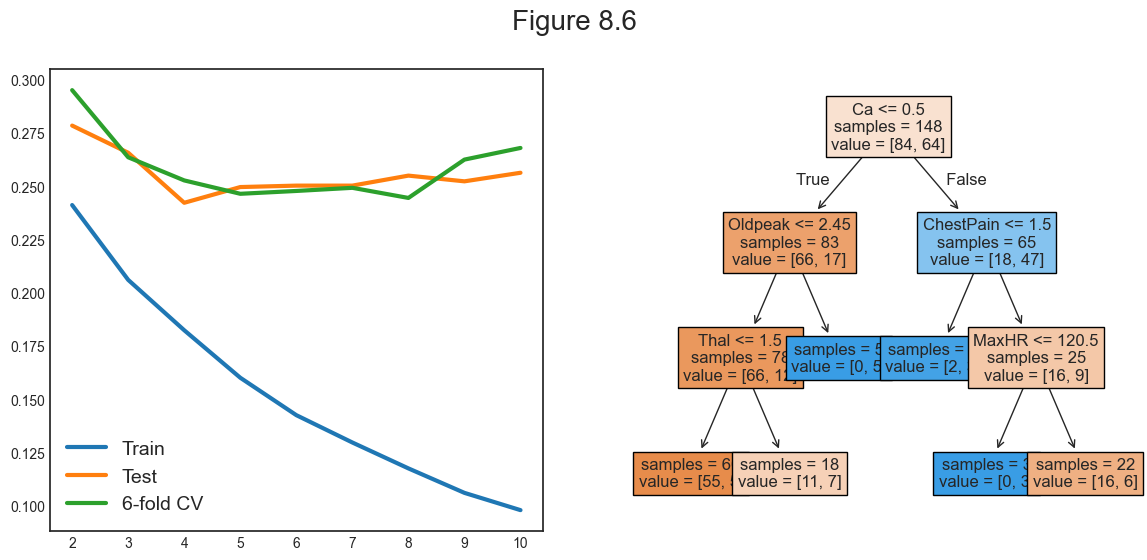

In [38]:
# Init
J = 10
params = range(2,11)
clf_scores = np.zeros((len(params),3))
best_score = 1  # agora estamos buscando o MENOR erro (1 - acurácia)

# Loop over all parameters
for i, k in enumerate(params):
    
    # Model
    tree = DecisionTreeClassifier(max_leaf_nodes=k)
    
    # Loop J times
    temp_scores = np.zeros((J, 3))
    for j in range(J):

        # Split
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        m = tree.fit(X2_train, y2_train)

        # Erro de classificação (1 - acurácia)
        temp_scores[j, 0] = 1 - accuracy_score(y2_train, m.predict(X2_train))
        temp_scores[j, 1] = 1 - accuracy_score(y2_test, m.predict(X2_test))

        # Validação cruzada
        kf6 = KFold(n_splits=6)
        cv_error = 1 - cross_val_score(tree, X2_train, y2_train, cv=kf6, scoring='accuracy').mean()
        temp_scores[j, 2] = cv_error

        # Salva o melhor modelo
        if cv_error < best_score:
            best_model = m
            best_score = cv_error
        
    # Média dos erros
    clf_scores[i, :] = np.mean(temp_scores, axis=0)

make_figure_8_6b()

***O Gráfico (Esquerda)***

* ***Eixo X:*** Mostra a complexidade do Modelo. O hiperparâmetro `max_leaf_nodes` (o número máximo de nós-folha), que varia de 2 a 10. Quanto mais folhas, mais complexa e "profunda" a árvore pode ser.
* ***Eixo Y:*** Mostra o erro do modelo. Utilizamos o erro de acurácia (`1 - accuracy_score`), onde um valor menor indica um desempenho melhor.

O gráfico exibe três curvas distintas:
  * Train (Azul - Erro de Treino): O erro do modelo nos mesmos dados que ele usou para aprender.
  * Test (Laranja - Erro de Teste): O erro do modelo em dados novos, que ele nunca viu antes (`X2_test`). Esta é a medida mais importante do poder de generalização do modelo.
  * 6-fold CV (Verde - Erro de Validação Cruzada): Uma estimativa mais robusta do erro de teste. Em vez de usar um único conjunto de teste, a validação cruzada (neste caso, com 6 "dobras" ou `KFold(n_splits=6)`) cria múltiplas divisões de treino/validação para gerar uma média de desempenho mais estável.

O ponto ideal de complexidade é aquele que minimiza o erro de validação cruzada (CV) ou de teste. No gráfico, vemos que o menor erro ocorre quando a árvore tem 6 nós-folha.

***A Árvore (Direita)***

A árvore de decisão mostrada à direita é o resultado final deste processo de otimização.

Ela possui exatamente 6 nós-folha (as caixas na base da árvore), que foi o número identificado como ótimo pelo gráfico. Ela representa o melhor equilíbrio encontrado: ela é complexa o suficiente para capturar as relações importantes nos dados (Oldpeak, Ca, etc.), mas não tão complexa a ponto de sofrer *overfitting*. Ou seja, ***é o modelo com a maior probabilidade de generalizar bem para novas observações***.

### 3. Conjunto de Árvores (*Ensemble of Trees*)

Anteriormente estávamos modelando uma única árvore de decisão. Do ponto de vista teórico, uma única árvore de decisão pode ser muito instável, pois pequenas variações nos dados podem levar a grandes mudanças na estrutura da árvore. 

Em outras palavras, a utilização de uma única árvore é questionável se os dados de treinamento tiverem valores atípicos ou ruídos, isso pode resultar em um modelo que não generaliza bem para novos dados. Ou seja, o modelo apresentará alta variância, o que significa que ele pode se ajustar muito bem aos dados de treinamento, mas falhar em prever novos dados.

Nesse sentido, surgiram os ***métodos de ensemble (métodos de conjunto)***, que combinam várias árvores de decisão para melhorar a robustez e a precisão preditiva. Esses métodos são fundamentais para lidar com a variabilidade e a instabilidade das árvores individuais.

Os principais métodos de ensemble que veremos são:

* **Bagging (Bootstrap Aggregating)**: Combina previsões de várias árvores treinadas em subconjuntos aleatórios dos dados.
* **Florestas Aleatórias (Random Forests)**: Uma extensão do bagging que introduz aleatoriedade adicional na seleção de variáveis para cada divisão.
* **Boosting**: Um método que ajusta sequencialmente árvores de decisão, onde cada árvore tenta corrigir os erros da anterior.

### 3.1. *Bagging* (*Bootstrap Aggregating* / Ensacamento)

O nome *Bagging* vem de *Bootstrap Aggregating*, que é uma técnica que combina previsões de várias árvores de decisão para melhorar a precisão e reduzir a variância. A ideia é treinar várias árvores em subconjuntos aleatórios (provenientes da técnica de *bootstraping*) dos dados e, em seguida, combinar suas previsões.


<div style="text-align:center;">
    <img src="images\img_bagging_.png"  alt="Imagem" style="width: 650px;"/>
</div>



Ele funciona da seguinte maneira:

1. **Bootstrap**: Cria múltiplos subconjuntos de dados de treinamento a partir do conjunto original ($B$), selecionando aleatoriamente com reposição. Isso significa que algumas observações podem aparecer mais de uma vez em um subconjunto, enquanto outras podem não aparecer.
    * OBS: aproximadamente 36.8% das observações originais (em média) não aparecerão em uma amostra bootstrap específica. Isso se aplica a cada amostra bootstrap gerada para cada árvore no Bagging.
2. **Treinamento de Múltiplas Árvores**: Para cada subconjunto gerado, uma árvore de decisão é treinada. Isso resulta em várias árvores, cada uma treinada em um conjunto ligeiramente diferente de dados ($\hat{f}^{*}(.)$).
3. **Agregação**: As previsões de todas as árvores são combinadas para fazer uma previsão final. Para problemas de regressão, isso geralmente é feito calculando a média das previsões de todas as árvores. Para problemas de classificação, a classe mais frequente (votação majoritária) é escolhida.

$$
\hat{f}_{\text{bagging}}(x) = \frac{1}{B} \sum_{b=1}^{B} \hat{f}^{*b}(x)
$$

Em resumo, esse método obtem mais precisão porque ao treinar árvores em diferentes subconjuntos de dados, cada árvore individual pode ter um alto viés e/ou alta variância. No entanto, quando as previsões dessas árvores "ruidosas" são agregadas, os erros aleatórios tendem a se cancelar, resultando em um modelo combinado mais estável e com menor variância. 

***Out-of-Bag (OOB)***

Uma característica muito útil do *Bagging* é a capacidade de estimar o erro de generalização do modelo sem a necessidade de um conjunto de validação separado ou validação cruzada. Isso é feito através do ***erro Out-of-Bag (OOB)***. Como cada árvore no Bagging é treinada em um subconjunto bootstrap dos dados, algumas observações nunca são usadas para treinar uma árvore específica. Essas observações 'fora da bolsa' (out-of-bag) para uma dada árvore podem ser usadas como um conjunto de validação para essa árvore. O erro OOB é a média das previsões dessas observações OOB em todas as árvores, fornecendo uma estimativa não viesada do erro de teste do modelo

A estimativa OOB é um tipo de validação cruzada "quase-gratuita" onde cada ponto de dados do conjunto de treinamento é usado como ponto de validação para as árvores nas quais ele não foi incluído durante o bootstrap (Apenas as árvores que "não viram" a observação durante o treinamento).

Pode-se demonstrar que, com B suficientemente grande, o erro OOB é virtualmente equivalente ao erro de validação cruzada "leave-one-out". A abordagem OOB para estimar o erro de teste é particularmente conveniente ao realizar bagging em grandes conjuntos de dados para os quais a validação cruzada seria computacionalmente onerosa.

***Exemplo Prático: Bagging com o Conjunto de Dados Heart***

Agora vamos calcular a Acurácia do modelo para o conjunto de dados `Heart` usando diferentes números de árvores.

In [39]:
# Init
params = range(2,50)
bagging_scores = np.zeros((len(params),2))
J = 30;

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=k, oob_score=True)
        bagging.fit(X2_train,y2_train)
        temp_scores[j,0] = bagging.score(X2_test, y2_test)
        temp_scores[j,1] = bagging.oob_score_

    # Average
    bagging_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

A seguir, apresentamos o gráfico que ilustra a performance do modelo Bagging no conjunto de dados Heart, comparando a acurácia no conjunto de teste com a estimativa Out-of-Bag (OOB) em função do número de árvores.

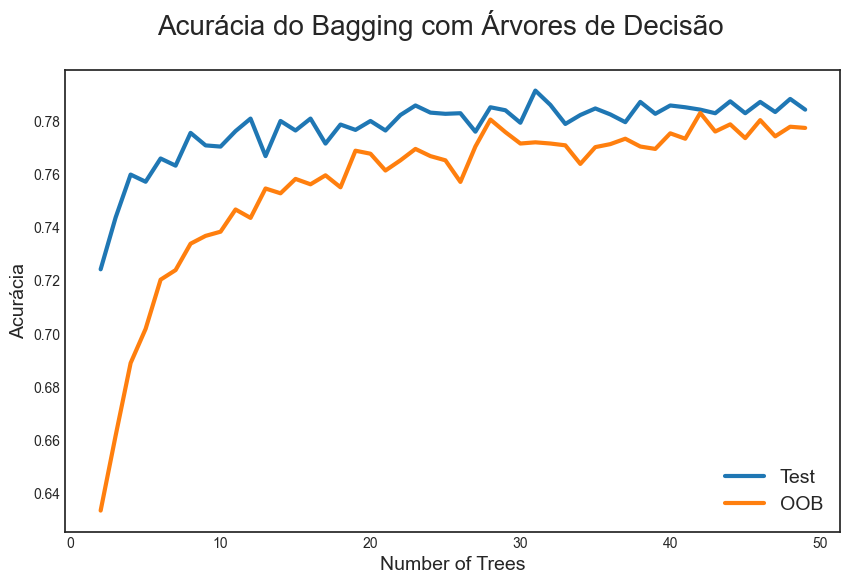

In [36]:
# Make new figure 1
def make_new_figure_1():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    fig.suptitle("Acurácia do Bagging com Árvores de Decisão")

    # Plot scores
    ax.plot(params, bagging_scores);
    ax.legend(['Test','OOB']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('Acurácia');

make_new_figure_1()

* ***Test:*** É a performance do modelo Bagging completo (o ensemble de todas as k árvores) avaliada em um conjunto de dados de teste (ou validação) completamente separado e independente do conjunto de treinamento.
* ***OOB:*** É uma estimativa da performance do modelo em dados não vistos que é calculada internamente durante o processo de treinamento do Bagging, sem a necessidade de um conjunto de teste separado.

***Agora, não podemos mais desenhar árvores, pois temos muitas delas***.

No entanto, é possível obter um resumo geral da importância de cada preditor usando o RSS (para árvores de regressão bagging) ou o índice de Gini (para árvores de classificação bagging). No caso de árvores de regressão bagging, podemos registrar a quantidade total de redução do RSS devido a divisões em um determinado preditor, calculada a média de todas as árvores. Um valor alto indica um preditor importante. Da mesma forma, no contexto de árvores de classificação bagging, podemos somar a quantidade total de redução do índice de Gini devido a divisões em um determinado preditor, calculada a média de todas as árvores.

In [40]:
# Compute feature importance
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

Podemos dar uma olhada na importância de cada característica específica.

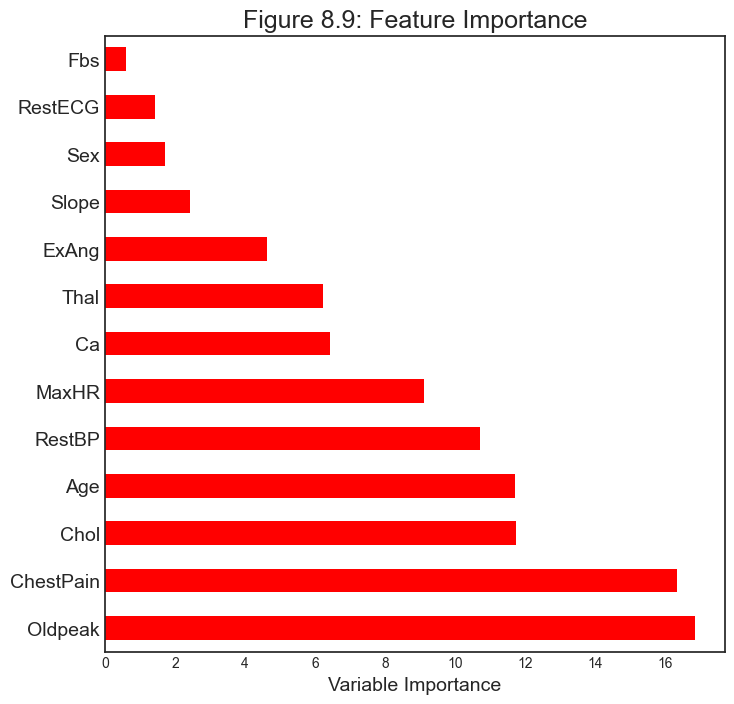

In [42]:
# Figure 8.9
def make_figure_8_9():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    ax.set_title('Figure 8.9: Feature Importance');

    # Plot feature importance
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
    h1.plot(kind='barh', color='r', ax=ax)
    ax.set_xlabel('Variable Importance'); 
    plt.yticks(fontsize=14);
    plt.gca().legend_ = None;

make_figure_8_9()

###

### 3.2. Florestas Aleatórias (*Random Forests*)

As Florestas Aleatórias são uma extensão do método de Bagging que introduz uma modificação importante com o objetivo de ***reduzir a correlação entre as árvores da floresta, o que leva a uma redução ainda maior da variância do modelo final***.

O *Bagging* consiste em treinar múltiplas árvores de decisão em amostras bootstrap e, em seguida, agregar suas previsões (por média, para regressão; por votação, para classificação). Isso já reduz a variância de uma única árvore.

Porém, se houver um preditor muito forte no conjunto de variáveis, é provável que ele seja escolhido como a primeira divisão em muitas (ou todas) as árvores. Como consequência, as árvores se tornam altamente correlacionadas entre si, o que limita a redução de variância obtida pela agregação.

As ***Random Forests*** introduzem aleatoriedade adicional ao processo de construção das árvores. Especificamente:

> A cada divisão de uma árvore, em vez de considerar todos os preditores disponíveis, o algoritmo escolhe aleatoriamente apenas um subconjunto de variáveis como candidatos à divisão.

Normalmente: 
* Se houver $p$ preditores no total, 
* Considera-se apenas $m = \sqrt{p}$ preditores em cada divisão (para regressão) ou $m = \sqrt{p} \approx \log_2(p)$ (para classificação, regra empírica).

Esse simples ajuste:
* Reduz a correlação entre as árvores,
* E melhora a performance preditiva do modelo agregado.

Em suma:
> Em uma Floresta Aleatória, a cada divisão de cada árvore, o algoritmo escolhe aleatoriamente apenas um subconjunto de variáveis (tipicamente $\sqrt{p}$), e realiza a divisão com base apenas nesse subconjunto.

Figura:

<div style="text-align:center;">
    <img src="images\RF.png"  alt="Imagem" style="width: 650px;"/>
</div>



Em outras palavras, ao construir uma floresta aleatória, em cada divisão na árvore, o algoritmo não tem permissão nem para considerar a maioria dos preditores disponíveis. 

Isso pode parecer loucura, mas tem uma justificativa inteligente. Suponha que haja um preditor muito forte no conjunto de dados, juntamente com vários outros preditores moderadamente fortes. Então, na coleção de árvores ensacadas, a maioria ou todas as árvores usarão esse preditor forte na divisão superior. Consequentemente, todas as árvores ensacadas parecerão bastante semelhantes entre si. Portanto, as previsões das árvores ensacadas serão altamente correlacionadas. 

Infelizmente, a média de muitas quantidades altamente correlacionadas não leva a uma redução tão grande na variância quanto a média de muitas quantidades não correlacionadas. Em particular, isso significa que o ensacamento não levará a uma redução substancial na variância em uma única árvore nesse cenário.

Florestas aleatórias superam esse problema forçando cada divisão a considerar apenas um subconjunto dos preditores .

***Resumo das Random Forests***

Ao construir uma árvore dentro de uma Floresta Aleatória:
* Primeiro, como no Bagging, o algoritmo extrai uma amostra bootstrap dos dados de treinamento.
* Depois, ao construir a árvore, a cada vez que uma divisão (split) é considerada:
  * Ele seleciona aleatoriamente $m$ preditores (um subconjunto de $p$),
  * E busca a melhor divisão somente entre esses $m$ preditores.
  * Esse processo se repete em cada divisão, até a árvore ser completamente construída (até max_depth, max_leaf_nodes ou outro critério de parada).

***comparando Bagging e Random Forests***

voltando a aplicação anterior, vamos comparar o desempenho do modelo Bagging com o modelo Random Forests.

In [43]:
# Init (takes a lot of time with J=30)
params = range(2,50)
forest_scores = np.zeros((len(params),2))
J = 30

# Loop over parameters
for i, k in enumerate(params):
    print("Computing k=%1.0f" % k, end ="")
    
    # Repeat J 
    temp_scores = np.zeros((J,2))
    for j in range(J):
        X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.5, random_state=j)
        forest = RandomForestClassifier(n_estimators=k, oob_score=True, max_features="sqrt")
        forest.fit(X2_train,y2_train)
        temp_scores[j,0] = forest.score(X2_test, y2_test)
        temp_scores[j,1] = forest.oob_score_
        
    # Average
    forest_scores[i,:] = np.mean(temp_scores, axis=0)
    print("", end="\r")

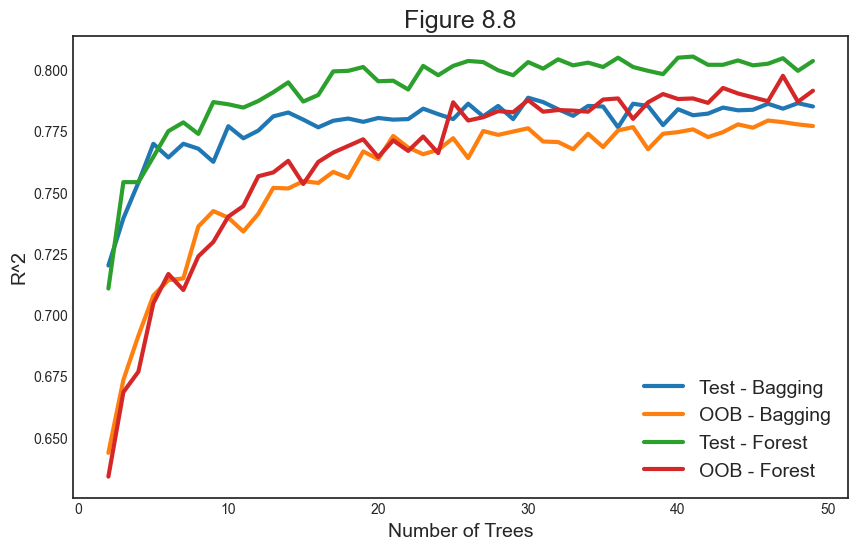

In [44]:
# Figure 8.8
def make_figure_8_8():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_title('Figure 8.8');

    # Plot scores
    ax.plot(params, bagging_scores);
    ax.plot(params, forest_scores);
    ax.legend(['Test - Bagging','OOB - Bagging', 'Test - Forest','OOB - Forest']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('R^2');

make_figure_8_8()

Vamos comparar a importância considerada para cada recurso/variável em cada método.

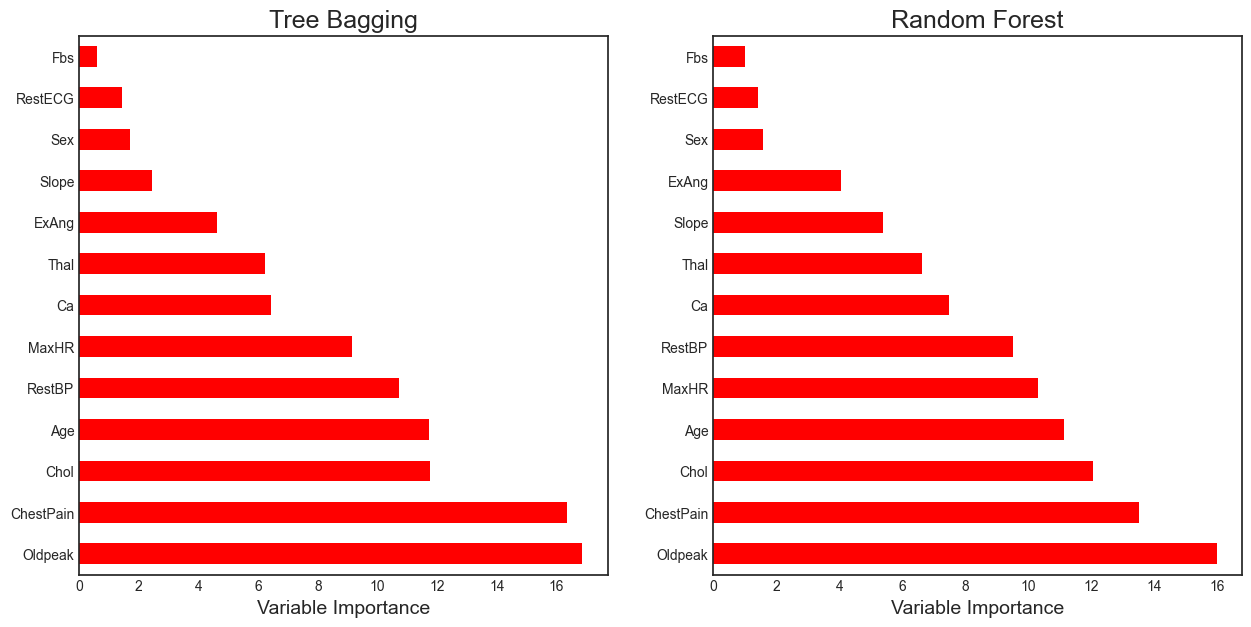

In [45]:
# Make new figure 2
def make_new_figure_2():
    
    # Init
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

    # Plot feature importance - Bagging
    h1 = pd.DataFrame({'Importance':feature_importances*100}, index=features)
    h1 = h1.sort_values(by='Importance', axis=0, ascending=False)
    h1.plot(kind='barh', color='r', ax=ax1)
    ax1.set_xlabel('Variable Importance'); 
    ax1.set_title('Tree Bagging')

    # Plot feature importance
    h2 = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=features)
    h2 = h2.sort_values(by='Importance', axis=0, ascending=False)
    h2.plot(kind='barh', color='r', ax=ax2)
    ax2.set_title('Random Forest')

    # All plots
    for ax in fig.axes:
        ax.set_xlabel('Variable Importance'); 
        ax.legend([])

make_new_figure_2()

Na figura, observamos que a classificação de importância das variáveis ​​é semelhante à do bagging e das florestas aleatórias, mas há diferenças.

Agora, vamos analisar a importância das florestas aleatórias usando o conjunto de dados genéticos `Khan`. Este conjunto de dados tem a peculiaridade de possuir um grande número de características e poucas observações.

In [47]:
# Load data
gene = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/Khan.csv')
print(len(gene))
gene.head()

83


,x,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V2299,V2300,V2301,V2302,V2303,V2304,V2305,V2306,V2307,V2308
0,2,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,...,-0.238511,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172
1,2,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,...,-0.657394,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395
2,2,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,...,-0.696352,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434
3,2,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,...,0.259746,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483
4,2,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,...,-0.200404,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966


5 linhas × 2309 colunas

O conjunto de dados tem 83 linhas e 2309 colunas.

Como é um conjunto de dados muito amplo , selecionar os recursos "corretos" é fundamental.

Observe também que não podemos executar regressão linear neste conjunto de dados.

In [48]:
# Reduce dataset size
gene_small = gene.iloc[:,0:202]
X = gene_small.iloc[:,1:]
y = gene_small.iloc[:,0]

Vamos agora fazer uma validação cruzada sobre o número de árvores e o número máximo de recursos considerados.

In [49]:
# Init (takes a lot of time with J=30)
params = range(50,150,10)
m_scores = np.zeros((len(params),3))
p = np.shape(X)[1]
J = 30;

# Loop over parameters
for i, k in enumerate(params):
    
    # Array of features
    ms = [round(p/2), round(np.sqrt(p)), round(np.log(p))]
    
    # Repeat L times
    temp_scores = np.zeros((J,3))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
    
        # Loop over values of m
        for index, m in enumerate(ms):
            forest = RandomForestClassifier(n_estimators=k, max_features=m, oob_score=True)
            forest.fit(X, y)
            temp_scores[j,index] = forest.oob_score_
        print("", end="\r")
            
    # Average
    m_scores[i,:] = np.mean(temp_scores, axis=0)

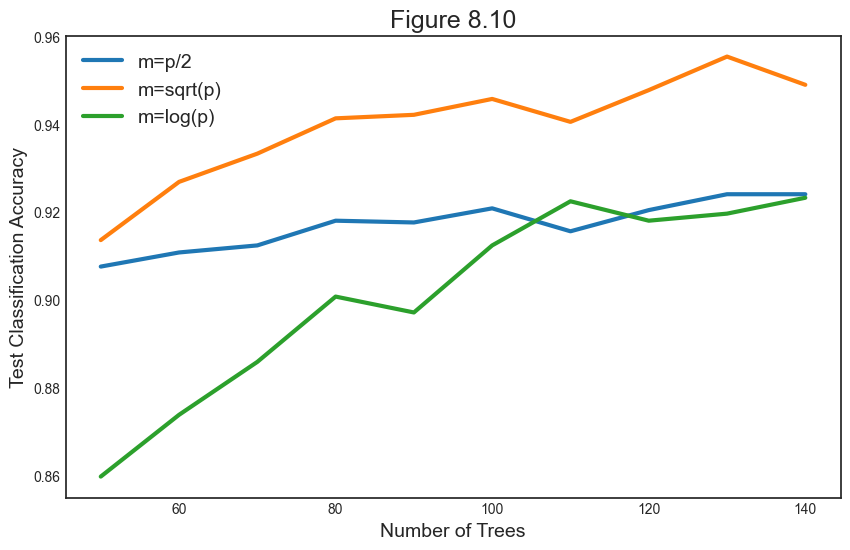

In [76]:
# Figure 8.10
def make_figure_8_10():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_title('Figure 8.10');

    # Plot scores
    ax.plot(params, m_scores);
    ax.legend(['m=p/2','m=sqrt(p)','m=log(p)']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

make_figure_8_10()

Parece que as melhores pontuações são alcançadas com poucos recursos e muitas árvores.

### 3.3. Boosting

***Boosting*** é um algoritmo de aprendizado ensemble, em que:
* Modelos são treinados sequencialmente, cada um tentando corrigir os erros do anterior.
* A combinação final é uma soma ponderada desses modelos.
* O foco é reduzir o viés do modelo, aumentando progressivamente sua complexidade.
* Os exemplos mal classificados ganham mais peso nas próximas iterações.
* Ele pode ser aplicado tanto a problemas de **regressão** quanto de **classificação**, com adaptações na função de perda.

A Figura ilustra a lógica do algoritmo:

<div style="text-align:center;">
    <img src="images\alg_boosting.png"  alt="Imagem" style="width: 650px;"/>
</div>

- Cada nova árvore é treinada sobre os **resíduos** (erros) do modelo anterior;
- O modelo é atualizado de forma **aditiva** com uma versão suavizada da nova árvore;
- O processo se repete até alcançar o número de iterações desejado.


***Algoritmo***

Definição formal do algoritmo de Boosting:


<div style="text-align:center;">
    <img src="images\algor_boosting.png"  alt="Imagem" style="width: 650px;"/>
</div>

**Passo 1:**  
* Inicialize o modelo com uma constante ou com zero:

$$
\hat{f}(x) = 0 \quad \text{e} \quad r_i = y_i \quad \text{para todo } i
$$


**Passo 2:**  
Para $b = 1, 2, \dots, B$, repita:

**(a)** Ajuste uma árvore $\hat{f}^{b}$ com $d$ divisões (isto é, $d+1$ folhas) sobre os dados $(X, r)$.

**(b)** Atualize a função preditora com uma versão suavizada da nova árvore:

$$
\hat{f}(x) \leftarrow \hat{f}(x) + \lambda \hat{f}^{b}(x)
$$

**(c)** Atualize os resíduos:

$$
r_i \leftarrow r_i - \lambda \hat{f}^{b}(x_i)
$$

**Passo 3:**  
O modelo final é a soma ponderada das $B$ árvores:

$$
\hat{f}(x) = \sum_{b=1}^{B} \lambda \hat{f}^{b}(x)
$$

***Interpretação***

- $\lambda$ é a **taxa de aprendizado** (*learning rate*), que controla o quanto cada árvore contribui para a predição final;
- Os **resíduos** $r_i$ representam o erro ainda não explicado — e por isso são usados como alvo nas próximas iterações;
- Cada árvore é treinada **sobre os resíduos atualizados**, aprendendo **a direção do gradiente da função de perda** (por isso o nome *Gradient* Boosting);
- O modelo final é a **soma de correções sucessivas**.


In [77]:
# Init , oob_score=True
params = range(50,150,10)
boost_scores = np.zeros((len(params),3))
p = np.shape(X)[1]
J = 30

# Loop over parameters
for i, k in enumerate(params):
    
    # Repeat L times
    temp_scores = np.zeros((J,3))
    for j in range(J):
        print("Computing k=%1.0f (iter=%1.0f)" % (k,j+1), end ="")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, random_state=j)
    
        # First score: random forest
        forest = RandomForestClassifier(n_estimators=k, max_features="sqrt")
        forest.fit(X_train, y_train)
        temp_scores[j,0] = forest.score(X_test, y_test)

        # Second score: boosting with 1-split trees
        boost1 = GradientBoostingClassifier(learning_rate=0.01, max_depth=1, n_estimators=k, max_features="sqrt")
        boost1.fit(X_train, y_train)
        temp_scores[j,1] = boost1.score(X_test, y_test)

        # Third score: boosting with 1-split trees
        boost2 = GradientBoostingClassifier(learning_rate=0.01, max_depth=2, n_estimators=k, max_features="sqrt")
        boost2.fit(X_train, y_train)
        temp_scores[j,2] = boost2.score(X_test, y_test)
        print("", end="\r")
    
    # Average
    boost_scores[i,:] = np.mean(temp_scores, axis=0)

Vamos comparar boosting e a floresta aleatória

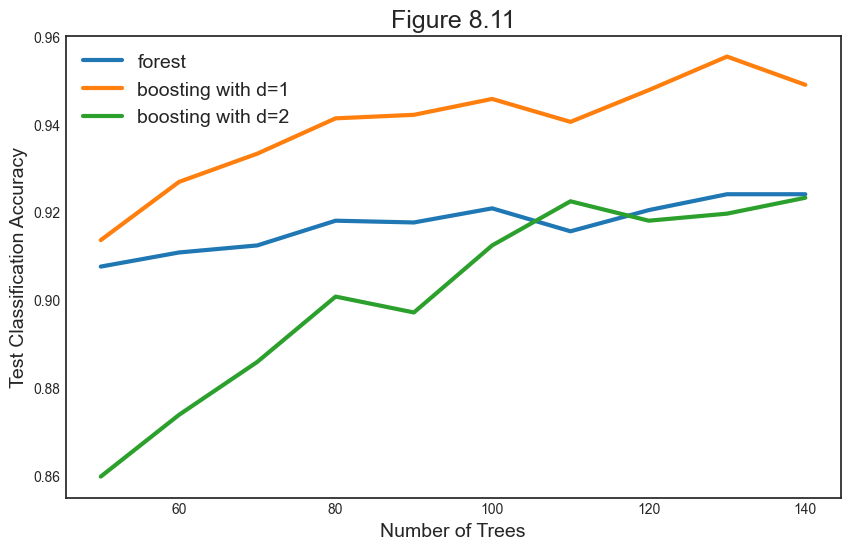

In [78]:
# Figure 8.11
def make_figure_8_11():
    
    # Init
    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_title('Figure 8.11');

    # Plot scores
    ax.plot(params, m_scores);
    ax.legend(['forest','boosting with d=1','boosting with d=2']);
    ax.set_xlabel('Number of Trees'); ax.set_ylabel('Test Classification Accuracy');

make_figure_8_11()

### 3.4. Bayesian Regression Trees (BART)

BART (Bayesian Additive Regression Trees) é um modelo de aprendizado de máquina que combina a flexibilidade das árvores de decisão com a robustez da inferência bayesiana. Ele é projetado para capturar relações complexas entre variáveis preditoras e a variável resposta, enquanto fornece incertezas associadas às previsões.

### 4. Aplicações em Python

Vamos aplicar Random Forests, Boosting e Bagging ao conjunto de dados Heart com os pacotes `sklearn` e `xgboost` do Python. Vamos comparar o desempenho de cada método usando validação cruzada.
```


***Aplicação para Regressão***

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# MODELOS DE MACHINE LEARNING PARA REGRESSÃO
# Regressão com Decision Trees
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
# Boosting
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
# Bagging
bag_reg1 = BaggingRegressor(estimator=tree_reg1, n_estimators=100, random_state=42)
bag_reg2 = BaggingRegressor(estimator=tree_reg2, n_estimators=100, random_state=42)


# Avaliação com base no MSE
def evaluate_model(model, X, y):
    neg_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -neg_mse_scores  # transformando em MSE positivo
    return mse_scores.mean(), mse_scores.std()

# Avaliando todos os modelos
mse_rf, std_rf = evaluate_model(rf_reg, X, y)
mse_gb, std_gb = evaluate_model(gb_reg, X, y)
mse_bag1, std_bag1 = evaluate_model(bag_reg1, X, y)
mse_bag2, std_bag2 = evaluate_model(bag_reg2, X, y)

# Exibindo os resultados
print("Random Forest MSE: {:.4f} ± {:.4f}".format(mse_rf, std_rf))
print("Boosting MSE: {:.4f} ± {:.4f}".format(mse_gb, std_gb))
print("Bagging MSE: {:.4f} ± {:.4f}".format(mse_bag1, std_bag1))
print("Bagging (Pruned Trees) MSE: {:.4f} ± {:.4f}".format(mse_bag2, std_bag2))


Random Forest MSE: 0.3284 ± 0.2005
Boosting MSE: 0.4738 ± 0.3342
Bagging MSE: 0.3290 ± 0.1958
Bagging (Pruned Trees) MSE: 0.3624 ± 0.1973


Random Forest apresentou o menor erro médio quadrático (MSE), embora o Bagging com árvore não podada tenha desempenho muito próximo.

Boosting teve o pior desempenho nesse caso (maior MSE e desvio padrão).

***Outros Modelos baseados em árvores (mais avançados)***

* XGBoost (xgboost): Gradient Boosting otimizado com regularização L1/L2.
  * Extremamente rápido e preciso.
  * Venceu várias competições do Kaggle.

* LightGBM (lightgbm): Versão otimizada de boosting da Microsoft.
  * Mais rápido que XGBoost em grandes datasets.
  * Usa histogramas para acelerar os splits.

* CatBoost (catboost)
  * Desenvolvido pela Yandex.
  * Ótimo para dados com variáveis categóricas.
  * Muito eficiente e geralmente requer menos pré-processamento.



In [121]:
# Instalação dos pacotes (execute no terminal ou notebook se ainda não tiver)
# !pip install xgboost lightgbm catboost

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Modelos externos
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Regressão com Decision Trees
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Gradient Boosting tradicional
gb_reg = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Bagging
bag_reg1 = BaggingRegressor(estimator=tree_reg1, n_estimators=100, random_state=42)
bag_reg2 = BaggingRegressor(estimator=tree_reg2, n_estimators=100, random_state=42)

# XGBoost
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, verbosity=0)

# LightGBM
lgbm_reg = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# CatBoost
cat_reg = CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)

# Avaliação com base no MSE
def evaluate_model(model, X, y):
    neg_mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -neg_mse_scores  # transformando em MSE positivo
    return mse_scores.mean(), mse_scores.std()

# Avaliando todos os modelos
mse_rf, std_rf = evaluate_model(rf_reg, X, y)
mse_gb, std_gb = evaluate_model(gb_reg, X, y)
mse_bag1, std_bag1 = evaluate_model(bag_reg1, X, y)
mse_bag2, std_bag2 = evaluate_model(bag_reg2, X, y)
mse_xgb, std_xgb = evaluate_model(xgb_reg, X, y)
mse_lgbm, std_lgbm = evaluate_model(lgbm_reg, X, y)
mse_cat, std_cat = evaluate_model(cat_reg, X, y)

# Exibindo os resultados
print("Random Forest MSE: {:.4f} ± {:.4f}".format(mse_rf, std_rf))
print("Boosting (sklearn) MSE: {:.4f} ± {:.4f}".format(mse_gb, std_gb))
print("Bagging MSE: {:.4f} ± {:.4f}".format(mse_bag1, std_bag1))
print("Bagging (Pruned Trees) MSE: {:.4f} ± {:.4f}".format(mse_bag2, std_bag2))
print("XGBoost MSE: {:.4f} ± {:.4f}".format(mse_xgb, std_xgb))
print("LightGBM MSE: {:.4f} ± {:.4f}".format(mse_lgbm, std_lgbm))
print("CatBoost MSE: {:.4f} ± {:.4f}".format(mse_cat, std_cat))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4737
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 201
[LightGBM] [Info] Start training from score 2,863636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LightGBM e CatBoost tiveram os melhores desempenhos médios, com os menores MSEs e desvios padrão relativamente baixos

Uma vez que você identificou o modelo mais preciso (com menor MSE ou RMSE, por exemplo), você pode usá-lo para gerar previsões normalmente com o método .predict().

É possível fazer uma rotina para encontrar os melhore parãmetros.

In [122]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 5, 7],
    'n_estimators': [50, 100, 200]
}

lgbm = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(lgbm, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X, y)

print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor MSE:", -grid_search.best_score_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4737
[LightGBM] [Info] Number of data points in the train set: 66, number of used features: 201
[LightGBM] [Info] Start training from score 2,863636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

https://www.automl.org/automl/

### 5. Considerações Finais

